# Electrode array placement tool

This notebook was made to get arrays of catheter positions to save from the simulations

In [6]:
# Load libraries
import os,sys
import numpy as np
import vtk
from vtk.util.numpy_support import numpy_to_vtk,numpy_to_vtkIdTypeArray,vtk_to_numpy
import matplotlib.pyplot as plt
from copy import deepcopy

upperDir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(upperDir,'aux-functions'))
import egm_processing as egmp
import IgbHandling as igb
import quick_visualization as qv
from StandardVTKObjects import EGMColormap
from CatheterObjects import CatheterClass,CatheterGroup
from DirectionTrackingCalculator import VelocityCalculator,VelocityAnalyzer
from SourceTrackingCalculator import SourceTrackingCalculator

from UserInterfaceFunctions import FancyElectrodePlacementStyle as MouseInteractor
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load anatomy and select electrode type...

In [7]:
anatomyPath = '/home/vgmarques/Documents/Code/source-detection/0_data/anatomy/model30Box'
modelName = 'model24-30Box'
FullCell = igb.LoadCellFile(anatomyPath,modelName,[50,51])
Anatomy,veIndexes = igb.GetDataIndexes(anatomyPath,modelName,FullCell,validCells = [50,51])
scale = 1 # mm

CatheterObj = CatheterClass('HDGrid-4')

{'x': 137, 'y': 117, 'z': 77, 't': 1, 'type': 'byte', 'architecture': 'lsb', 'comments': []}
uint8


### ... Or create your own electrode template

The following templates are available in the CatheterClass:

- HDGrid-4: 4x4 electrode grid, 3 mm spacing in both directions
- Pentaray: 2-6-2 mm spacing per spline, 5 splines (of course)
- Lasso: circle with 10 electrodes. Not sure if is still working as it is an old implementation
- mega: 2 cm x 2 cm patch of 1 mm spaced electrodes in both directions
- mega2: same as mega but with 2 mm spacing
- mega3: same as mega but with 3 mm spacing
___

If you want to create your own template, you can modify the cell below to your needs.
** Do not run this cell if you don't want to create a template as it will mess up with the catheter array **

There are two options: 1) use the template for a grid-like shape or 2) make a generic arrangement

The important part is that you have a ElectrodeTemplate parameter set for the class. Comment the one you are not using

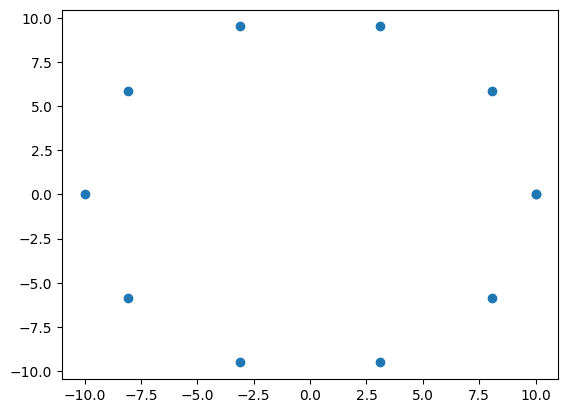

In [3]:
# #1) use the template for a grid-like shape
# # Edit first three lines and 
# CatheterObj.NumberOfElectrodesPerSpline = 4    
# CatheterObj.ElectrodeSpacing = np.ones(CatheterObj.NumberOfElectrodesPerSpline-1)*3 # mm 
# y = np.arange(4)*3 # Number of splines  and spline spacing (mm)

# x = np.arange(self.NumberOfElectrodesPerSpline)*self.ElectrodeSpacing[0] # Number of electrodes  and electrode spacing
# x = x-np.mean(x)
# y = y-np.mean(y)

# grid = np.meshgrid(x,y)
# CatheterObj.ElectrodesTemplate = np.array([grid[0].flatten(),grid[1].flatten()]).T
# CatheterObj.ProjectionFunction = CatheterObj.PlaceCatheter

#2) make a generic arrangement
# Example with lasso. Anything you can create works

r = 10
angles = np.linspace(0,360,r+1)*np.pi/180
x = r*np.cos(angles)
y = r*np.sin(angles) 
# Make template  
CatheterObj.ElectrodesTemplate = np.array([x,y]).T
# Set function to use
CatheterObj.ProjectionFunction = CatheterObj.PlaceCatheter


# Visualization
fig,ax = plt.subplots(1)
ax.scatter(CatheterObj.ElectrodesTemplate[:,0],CatheterObj.ElectrodesTemplate[:,1])

## Make anatomy actor and interactor

In [8]:
colors = vtk.vtkNamedColors()

try:
    plotData = signal
    cmap = 'egm'
except:
    plotData = np.ones(len(Anatomy))*-5
    cmap = 'heatmap'
# Data
nparray = Anatomy*scale
nCoords = nparray.shape[0]
#
verts = vtk.vtkPoints()
cells = vtk.vtkCellArray()

AnatomyActor,cbarActor,AnatomyData = qv.MakeIgbUnstructuredGridActor(FullCell,[50,51],
                                                                     plotData,smoothFilter=True,cmap=cmap,
                                                                     returnData = True,vmin=-5,vmax=5)
AnatomyActor.GetProperty().SetOpacity(0.9)

# useful functions
def MakePreviousPositionActor(renderer,currentPositions,append=False,previousPositions=None,previousSignal=None):
    sphereSource = vtk.vtkSphereSource()
    sphereSource.SetRadius(1/10)
    if not append:#timeIndex==1:
        previousSignal = np.array([1,0,0,0.5,0,0,0,0,0,0,0,0,0,0,0,0])
        previousPositions = currentPositions
    else:
        previousPositions = np.vstack([previousPositions,currentPositions])
        previousSignal = np.append(previousSignal,np.array([1,0,0,0.5,0,0,0,0,0,0,0,0,0,0,0,0]))
        
    PreviousActor = qv.MakeGlyphActor(previousPositions,
                                np.zeros_like(previousPositions),magnitudes = previousSignal,
                                cmap = 'jet',source = sphereSource)

    renderer.AddActor(PreviousActor)
    
    return renderer,previousPositions,previousSignal

In [16]:
catheterCenters = list()
catheterRotations = list()

t = 0

while True:
    # Renderer
    renderer = vtk.vtkRenderer()
    renderer.AddActor(AnatomyActor)
        
    
    ren_win = vtk.vtkRenderWindow()
    ren_win.SetSize([1400,800])
    ren_win.AddRenderer(renderer)
    ren_win.SetWindowName('Electrode Positioning')
    iren = vtk.vtkRenderWindowInteractor()
    iren.SetRenderWindow(ren_win)

    sphereSource = vtk.vtkSphereSource()
    sphereSource.SetRadius(1/5)
    
    
    if t==1:
        renderer,previousPositions,previousSignal = MakePreviousPositionActor(renderer,CatheterObj.ElectrodeCoordinates)
        renderer.SetActiveCamera(previousCamera)
    elif t>1:
        renderer,previousPositions,previousSignal = MakePreviousPositionActor(renderer,CatheterObj.ElectrodeCoordinates,
                                                                             append=True,
                                                                             previousPositions = previousPositions,
                                                                             previousSignal = previousSignal)
        renderer.SetActiveCamera(previousCamera)



    
    renderer.SetBackground(colors.GetColor3d('White'))

    # Add the custom style.
    style = MouseInteractor(AnatomyData,verbose=True)
    style.SetDefaultRenderer(renderer)

    # Add aditional parameters to the function that we passed (TODO: is this bad coding?)
    style.Catheter = CatheterObj
    style.Anatomy = Anatomy

    iren.SetInteractorStyle(style)

    ren_win.Render()
    iren.Initialize()
    iren.Start()

    CatheterObj = style.Catheter
    
    catheterCenters.append(CatheterObj.CatheterCenterIndex)
    catheterRotations.append(CatheterObj.Rotation)

    t += 1
    previousCamera = renderer.GetActiveCamera()


KeyboardInterrupt: 

## Make par file


In [13]:
N = len(catheterCenters)
print(os.getcwd())
with open('PosteriorWall_MoreOverlap.par','w') as f:
    f.write('-anatomyPath=/users/vgonalve/exec/anatomy/model30Box\n')
    f.write('-validCells\n50\n51\n') # endocardium
    f.write('-catheterNames\n')
    for i in range(N): f.write('HDg_%02d\n'%i)
    f.write('-catheterCenters\n')
    for i in range(N): f.write(str(catheterCenters[i])+'\n')
    f.write('-catheterRotations\n')
    for i in range(N): f.write(str(catheterRotations[i])+'\n')    

/home/vgmarques/Documents/Code/model-analyses/jupyter
